In [1]:
import os
import numpy as np
from pathlib import Path
# from music21 import *

from tqdm import tqdm
import pypianoroll
from pypianoroll import Track, Multitrack, BinaryTrack, StandardTrack

In [2]:
# Data
n_tracks = 5  # number of tracks
n_pitches = 84  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 16  # number of samples to extract from each song in the datset
n_measures = 4  # number of measures per sample
beat_resolution = 12  # temporal resolution of a beat (in timestep)
programs = [0, 0, 25, 33, 48]  # program number for each track
is_drums = [True, False, False, False, False]  # drum indicator for each track
track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']  # name of each track
tempo = 120

In [3]:
measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)
assert 24 % beat_resolution == 0, (
    "beat_resolution must be a factor of 24 (the beat resolution used in "
    "the source dataset)."
)
assert len(programs) == len(is_drums) and len(programs) == len(track_names), (
    "Lengths of programs, is_drums and track_names must be the same."
) 

In [4]:
# !mkdir -p data

# !gdown -O data/lpd_5_cleansed.tar.gz https://drive.google.com/uc?id=1yz0Ma-6cWTl6mhkrLnAVJ7RNzlQRypQ5
# !gdown -O data/id_lists_amg.tar.gz https://drive.google.com/uc?id=1hp9b_g1hu_dkP4u8h46iqHeWMaUoI07R
# !gdown -O data/id_lists_lastfm.tar.gz https://drive.google.com/uc?id=1mpsoxU2fU1AjKopkcQ8Q8V6wYmVPbnPO

# !tar zxf data/lpd_5_cleansed.tar.gz -C data/
# !tar zxf data/id_lists_amg.tar.gz -C data/
# !tar zxf data/id_lists_lastfm.tar.gz -C data/

In [5]:
# dataset_root = Path("data/lpd_5/lpd_5_cleansed/")

# id_list = []
# for path in os.listdir("data/amg"):
#     filepath = os.path.join("data/amg", path)
#     # print(path)
    
#     if os.path.isfile(filepath):
#         with open(filepath) as f:
#             id_list.extend([line.rstrip() for line in f])
# id_list = list(set(id_list))

In [6]:
# def msd_id_to_dirs(msd_id):
#     """Given an MSD ID, generate the path prefix.
#     E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
#     return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

In [7]:
# data = []
# max_num = 5000
# unsampled = 0
# file_idx = 0
# bar_num = 4

# for msd_id in tqdm(id_list):
#     song_dir = dataset_root / msd_id_to_dirs(msd_id)
#     multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
#     multitrack.pad_to_same()
#     # (shape: n_timesteps x n_pitches)
#     multitrack.set_resolution(beat_resolution)
#     # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
#     pianoroll = multitrack.stack()
    
#     pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
    
#     # pianoroll = np.pad(pianoroll, ((0, 0), (0,0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
#     n_total_measures = multitrack.get_max_length() // measure_resolution
#     candidate = n_total_measures - n_measures
#     target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    
#     for idx in np.random.choice(candidate, target_n_samples, False):
#         start = idx * measure_resolution
#         end = (idx + n_measures) * measure_resolution
        
#         if (pianoroll.sum(axis=(1, 2)) < 10).any():
#             continue
        
#         #tracks = []
#         #for trk, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
#         #    tracks.append(StandardTrack(name=track_name, program=program, is_drum=is_drum, pianoroll=(pianoroll[trk, start:end] > 0.5)))
#         #multi = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
#         # print(pianoroll[:, start:end].reshape(n_tracks, 4, -1, n_pitches).shape)
#         try:
#             data.append(pianoroll[:, start:end].reshape(n_tracks, bar_num, -1, n_pitches)) # reshape 48 * 16
#         except Exception as e:
#             # print(pianoroll[:, start:end].shape, 'Exception')
#             unsampled += 1
#             pass
#         #multi.write(f'./temp_midi_data/dataset_{file_idx}.mid')
#     file_idx += 1
#     if file_idx > max_num-1:
#         print(file_idx)
#         break

# data = np.stack(data)
# print(f"Successfully collect {len(data)} samples from {len(id_list)} songs")
# print(f"Data shape : {data.shape}")
# print(f"unsampled : {unsampled}")
# dataset = data.transpose(0, 2, 3, 4, 1)
# print(f'finally dataset {dataset.shape}')

In [8]:
# dataset.dtype

In [9]:
# np.save('./run/dataset2.npy', dataset)

In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import RandomNormal, TruncatedNormal
from IPython import display
import pypianoroll
from pypianoroll import Multitrack, StandardTrack, BinaryTrack
# import muspy
import tensorflow as tf
import random
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

2021-12-13 21:30:57.045364: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [11]:
strategy = tf.distribute.MirroredStrategy()
FLAG = True
if strategy.num_replicas_in_sync  > 1 and FLAG:
    MULTIPLE_BATCH = strategy.num_replicas_in_sync
    print(f'분산환경 사용 >> GPU: {MULTIPLE_BATCH}')
else:
    print(f'분산환경 미사용')
    MULTIPLE_BATCH = 1

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
분산환경 사용 >> GPU: 2


2021-12-13 21:30:58.585239: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-13 21:30:58.697286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 21:30:58.698569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.72GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-13 21:30:58.698691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 21:30:58.699915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:

In [12]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

In [13]:
seed_everything(9903)

In [14]:
# run params
SECTION = 'compose'
RUN_ID = '77'
DATA_NAME = 'lpd_5'
RUN_FOLDER = f'run/{SECTION}/'
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights'))
    os.makedirs(os.path.join(RUN_FOLDER, 'samples'))
    os.makedirs(os.path.join(RUN_FOLDER, 'sample_data'))

In [15]:
input_dim = (4, 48, 84, 5)
beat_resolution = 12
latent_dim = 128
condition_track_idx = 1
n_tracks = 5

In [16]:
CONV_KERNEL_INIT = TruncatedNormal(stddev=0.05)
DENSE_KERNEL_INIT = TruncatedNormal(stddev=0.05)

def conv_layer( i, f, k, s, a='relu', bn=True):
        x = Conv3D(filters=f, kernel_size=k,
        strides=s, kernel_initializer=CONV_KERNEL_INIT)(i)
        if bn:
            x = BatchNormalization()(x)
        if a=='relu':
            x = Activation(a)(x)
        if a=='lrelu':
            x = LeakyReLU()(x)
        return x

def tconv_c( i, c, f, k, s, a='relu', bn=True):
    x = Conv3DTranspose(filters=f, kernel_size=k,
    strides=s, kernel_initializer=CONV_KERNEL_INIT)( tf.concat((i, c), -1) )
    if bn:
        x = BatchNormalization()(x)
    if a=='relu':
        x = Activation(a)(x)
    if a=='lrelu':
        x = LeakyReLU()(x)

    return x

def build_gen():
    n_track = n_tracks - 1
    c = Input(shape=(input_dim[:-1]+(1,)))
    input_z = Input(shape=latent_dim)

    # encoder_pitch_time
    pt_1 = conv_layer(c, f=16, k=(1, 1, 12), s=(1, 1, 12))
    pt_2 = conv_layer(pt_1, f=32, k=(1, 3, 1), s=(1, 3, 1))

    # encoder_time_pitch
    tp_1 = conv_layer(c, f=16, k=(1, 3, 1), s=(1, 3, 1))
    tp_2 = conv_layer(tp_1, f=32, k=(1, 1, 12), s=(1, 1, 12))

    # shared = tf.concat((tp_2, pt_2), -1)
    shared = Concatenate(axis=-1)([tp_2, pt_2])

    # encoder_shared
    s1 = conv_layer(shared, f=64, k=(1, 4, 3), s=(1, 4, 2))
    s2 = conv_layer(s1, f=128, k=(1, 4, 3), s=(1, 4, 3))
    s3 = conv_layer(s2, f=256, k=(4, 1, 1), s=(4, 1, 1))

    # ---------------generator ------------------------------
    h = input_z
    h = tf.expand_dims(  tf.expand_dims(   tf.expand_dims(  h,  1 ) , 1 ) , 1 )

    # shared
    h = tconv_c(h, s3, f=512, k=(4, 1, 1), s=(4, 1, 1))
    h = tconv_c(h, s2, f=256, k=(1, 4, 3), s=(1, 4, 3))
    h = tconv_c(h, s1, f=128, k=(1, 4, 3), s=(1, 4, 2))

    # pitch-time-private
    s1 = [tconv_c(h, tp_2, f=32, k=(1, 1, 12), s=(1, 1, 12)) for _ in range(n_track)]
    # 4, 16, 84
    s1 = [tconv_c(s1[i], tp_1, f=16, k=(1, 3, 1), s=(1, 3, 1)) for i in range(n_track)]
    # 4, 48, 84

    # Time-pitch_private
    s2 = [tconv_c(h, pt_2, f=32, k=(1, 3, 1), s=(1, 3, 1)) for _ in range(n_track)]
    # 4, 48, 7
    s2 = [tconv_c(s2[i], pt_1, f=16, k=(1, 1, 12), s=(1, 1, 12)) for i in range(n_track)]
    # 4, 48, 84

    h = [tf.concat((s1[i], s2[i]), -1) for i in range(n_track)]

    tconv3d = lambda i, f, k, s: Conv3DTranspose(filters=f, kernel_size=k, strides=s, 
                                                    kernel_initializer=CONV_KERNEL_INIT, activation='tanh')(i)
    batchNorm = lambda x: BatchNormalization(trainable=True)(x)
    # merge private net
    h = [ batchNorm(tconv3d(h[i], f=1, k=(1, 1, 1), s=(1, 1, 1))) for i in range(n_track)  ] # 4, 48, 84

    out = tf.concat((h[:condition_track_idx] + [c] + h[condition_track_idx:]), -1)
    return Model([c, input_z], out)

In [17]:
with strategy.scope():
    generator = build_gen()
generator.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [18]:
def Discriminator( tensor_in, N_track=5):#, condition_track=None):
    conv_layer = lambda i, f, k, s: LeakyReLU()(Conv3D(filters=f, kernel_size=k, strides=s)(i))

    #h = tensor_in
    # tensor_in = tensor_in_1 #Concatenate(axis=-1)([tensor_in_1, condition_track])
    h = tensor_in

    # Compute chroma feature
    n_beats = h.get_shape()[2] // beat_resolution
    reshaped = tf.reshape(
        tensor_in, (-1, h.get_shape()[1], n_beats, beat_resolution,
                    h.get_shape()[3], h.get_shape()[4]))
    summed = tf.reduce_sum(reshaped, 3)
    factor = int(h.get_shape()[3]) // 12
    remainder = int(h.get_shape()[3]) % 12
    reshaped = tf.reshape(
        summed[..., :(factor * 12), :],
        (-1, h.get_shape()[1], n_beats, factor, 12, h.get_shape()[4]))
    chroma = tf.reduce_sum(reshaped, 3)                      # 4, 4, 12
    if remainder:
        chroma += summed[..., -remainder:, :]

    # Compute onset/offset feature
    padded = tf.pad(tensor_in[:, :, :-1],
                    ((0, 0), (0, 0), (1, 0), (0, 0), (0, 0)))
    on_off_set = tf.reduce_sum(tensor_in - padded, 3, True)  # 4, 48, 1

    # pitch-time private
    s1 = [conv_layer(h, f=16, k=(1, 1, 12), s=(1, 1, 12)) for _ in range(N_track)]

    s1 = [conv_layer(s1[i], f=32, k=(1, 3, 1), s=(1, 3, 1)) for i in range(N_track)]

    # time-pitch private

    s2 = [conv_layer(h, f=16, k=(1, 3, 1), s=(1, 3, 1)) for _ in range(N_track)]

    s2 = [conv_layer(s2[i], f=32, k=(1, 1, 12), s=(1, 1, 12)) for i in range(N_track)]

    h = [tf.concat((s1[i], s2[i]), -1) for i in range(N_track)]

    # merge private network
    h = [conv_layer(h[i], f=64, k=(1, 1, 1), s=(1, 1, 1)) for i in range(N_track)]

    h = tf.concat(h, -1)

    # shared net
    h = conv_layer(h, f=128, k=(1, 4, 3), s=(1, 4, 2))
    h = conv_layer(h, f=256, k=(1, 4, 3), s=(1, 4, 3))

    # chroma stream
    c = conv_layer(chroma, f=32, k=(1, 1, 12), s=(1, 1, 12))
    c = conv_layer(c, f=64, k=(1, 4, 1), s=(1, 4, 1))

    # onset/offset stream
    o = conv_layer(on_off_set, f=16, k=(1, 3, 1), s=(1, 3, 1))
    o = conv_layer(o, f=32, k=(1, 4, 1), s=(1, 4, 1))
    o = conv_layer(o, f=64, k=(1, 4, 1), s=(1, 4, 1))

    h = tf.concat((h, c, o), -1)

    # merged all streams
    h = conv_layer(h, f=512, k=(2, 1, 1), s=(1, 1, 1))
    
    #h = tf.reshape(h, (-1, h.get_shape()[-1])) # flatten
    h = Flatten()(h)
    h = LeakyReLU()(h)

    out = Dense(1, kernel_initializer=TruncatedNormal(stddev=0.05))(h)
    return out

def build_disc():
    tensor_in = Input(shape=input_dim)
    condition_track = Input(shape=(input_dim[:-1]+(1,)))
    disc_x = Discriminator(tensor_in, 5)
    
    disc_c = Discriminator(condition_track, 1) #

    out_1 = Concatenate(axis=-1)([disc_x, disc_c]) #
    out_1 = Flatten()(out_1) #
    out = LeakyReLU()(out_1) #
    out = Dense(1, kernel_initializer=TruncatedNormal(stddev=0.05))(out)
    return Model([tensor_in, condition_track], out) #

In [19]:
with strategy.scope():
    discriminator = build_disc()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 4, 48, 84, 5 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 4, 48, 84, 1 0                                            
__________________________________________________________________________________________________
conv3d_7 (Conv3D)               (None, 4, 48, 7, 16) 976         input_3[0][0]                    
__________________________________________________________________________________________________
conv3d_17 (Conv3D)              (None, 4, 16, 84, 16 256         input_3[0][0]                    
____________________________________________________________________________________________

In [20]:
#Number of input data samples in a batch
BATCH_SIZE = 256

#Shuffle buffer size for shuffling data
SHUFFLE_BUFFER_SIZE = 10000

#Preloads PREFETCH_SIZE batches so that there is no idle time between batches
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE

In [21]:
with strategy.scope():
    def prepare_dataset(filename):
        """Load the samples used for training."""
        
        data = np.load(filename)
        data = np.asarray(data[:, :, :, :, :], dtype=np.float32)  # {-1, 1}
        data = data / 127.0
        print('data shape = {}'.format(data.shape))

        dataset = tf.data.Dataset.from_tensor_slices(data)
        dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).repeat()
        dataset = dataset.batch(BATCH_SIZE*strategy.num_replicas_in_sync, drop_remainder=True)
        dataset = dataset.prefetch(PREFETCH_SIZE)
        return dataset
        
    DATASET_PATH = './run/dataset2.npy'

    dataset = prepare_dataset(DATASET_PATH)

data shape = (35290, 4, 48, 84, 5)


2021-12-13 21:31:20.042227: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 11383142400 exceeds 10% of free system memory.


In [22]:
def generator_loss(critic_fake_output):
    """ Wasserstein GAN loss
    (Generator)  -D(G(z|c))
    """
    return -tf.reduce_mean(critic_fake_output)


def wasserstein_loss(critic_real_output, critic_fake_output):
    """ Wasserstein GAN loss
    (Critic)  D(G(z|c)) - D(x|c)
    """
    return tf.reduce_mean(critic_fake_output) - tf.reduce_mean(
        critic_real_output)


def compute_gradient_penalty(critic, x, fake_x):
    
    c = tf.expand_dims(x[..., 0], -1)
    batch_size = x.get_shape().as_list()[0]
    eps_x = tf.random.uniform(
        [batch_size] + [1] * (len(x.get_shape()) - 1))  # B, 1, 1, 1, 1
    inter = eps_x * x + (1.0 - eps_x) * fake_x

    with tf.GradientTape() as g:
        g.watch(inter)
        disc_inter_output = critic((inter, c), training=True)
    grads = g.gradient(disc_inter_output, inter)
    slopes = tf.sqrt(1e-8 + tf.reduce_sum(
        tf.square(grads),
        axis=tf.range(1, grads.get_shape().ndims)))
    gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))
    
    return gradient_penalty

In [23]:
CHECK_DIR = os.path.join(RUN_FOLDER, 'weights')

In [24]:
@tf.function
def _generator_train_step(x, condition_track_idx=0):
    def generator_train_step(x=x, condition_track_idx=condition_track_idx):

        ############################################
        #(1) Update G network: maximize D(G(z|c))
        ############################################

        # Extract condition track to make real batches pianoroll
        c = tf.expand_dims(x[..., condition_track_idx], -1)

        # Generate batch of latent vectors
        z = tf.random.truncated_normal([BATCH_SIZE, latent_dim])

        with tf.GradientTape() as tape:
            fake_x = generator((c, z), training=True)
            fake_output = discriminator((fake_x, c), training=False)

            # Calculate Generator's loss based on this generated output
            gen_loss = generator_loss(fake_output)

        # Calculate gradients for Generator
        gradients_of_generator = tape.gradient(gen_loss,
                                            generator.trainable_variables)
        # Update Generator
        generator_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables))

        return gen_loss
    per_replica_loss = strategy.run(generator_train_step, args=(x, condition_track_idx))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_loss, axis=None)


In [25]:
@tf.function
def _critic_train_step(x, condition_track_idx=0):
    def critic_train_step(x=x, condition_track_idx=condition_track_idx):

        ############################################################################
        #(2) Update D network: maximize (D(x|c)) + (1 - D(G(z|c))|c) + GradientPenality() 
        ############################################################################

        # Extract condition track to make real batches pianoroll
        c = tf.expand_dims(x[..., condition_track_idx], -1)

        # Generate batch of latent vectors
        z = tf.random.truncated_normal([BATCH_SIZE, latent_dim])

        # Generated fake pianoroll
        fake_x = generator((c, z), training=False)

        # Update critic parameters
        with tf.GradientTape() as tape:
            real_output = discriminator((x,c), training=True)
            fake_output = discriminator((fake_x,c), training=True)
            critic_loss =  wasserstein_loss(real_output, fake_output)

        # Caculate the gradients from the real and fake batches
        grads_of_critic = tape.gradient(critic_loss,
                                                discriminator.trainable_variables)

        with tf.GradientTape() as tape:
            gp_loss = compute_gradient_penalty(discriminator, x, fake_x)
            gp_loss *= 10.0

        # Calculate the gradients penalty from the real and fake batches
        grads_gp = tape.gradient(gp_loss, discriminator.trainable_variables)
        gradients_of_critic = [g + ggp for g, ggp in
                                    zip(grads_of_critic, grads_gp)
                                    if ggp is not None]

        # Update Critic
        critic_optimizer.apply_gradients(
            zip(gradients_of_critic, discriminator.trainable_variables))

        return critic_loss + gp_loss
    per_replica_loss = strategy.run(critic_train_step, args=(x, condition_track_idx))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_loss, axis=None)

In [26]:
def load_melody_samples(n_sample=5):    
    """Load the samples used for evaluation."""
    
    sample_source_path = DATASET_PATH
    
    data = np.load(sample_source_path)
    data = np.asarray(data[:, :, :48, :, :], dtype=np.float32) # {-1, 1}
    # data = data / 127.0
    random_idx = np.random.choice(len(data), n_sample, replace=False) 
    
    sample_x = data[random_idx] # (10, 32, 128, 4) -> (10, 32, 128, 5)

    sample_z = tf.random.truncated_normal((n_sample, latent_dim))
    
    print("Loaded {} melody samples".format(len(sample_x)))

    return sample_x, sample_z

In [27]:
sample_x, sample_z = load_melody_samples(n_sample=10)

Loaded 10 melody samples


In [28]:
print(f'x={sample_x.shape}, z={sample_z.shape}')

x=(10, 4, 48, 84, 5), z=(10, 128)


In [29]:
epoch = 7000
n_dis_updates_per_gen_update = 5
condition_track_idx = 1
sample_c = tf.expand_dims(sample_x[..., condition_track_idx], -1)

In [30]:
# n_measures = 4  # number of measures per sample
# beat_resolution = 4  # temporal resolution of a beat (in timestep)
# programs = [0, 0, 25, 33, 48]  # program number for each track
# is_drums = [True, False, False, False, False]  # drum indicator for each track
# track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']  # name of each track
# tempo = 120

# measure_resolution = 4 * beat_resolution
# tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)
# assert 24 % beat_resolution == 0, (
#     "beat_resolution must be a factor of 24 (the beat resolution used in "
#     "the source dataset)."
# )
# assert len(programs) == len(is_drums) and len(programs) == len(track_names), (
#     "Lengths of programs, is_drums and track_names must be the same."
# ) 

In [31]:
def save_pianoroll( pianoroll, programs, is_drums, tempo_array,
                   beat_resolution, lowest_pitch, step=0):
    """Saves a batched pianoroll array to a npz file."""
    if pianoroll.ndim != 5:
        raise ValueError("Input pianoroll array must have 5 dimensions.")
    if pianoroll.shape[-1] != len(programs):
        raise ValueError("Length of `programs` does not match the number of "
                         "tracks for the input array.")
    if pianoroll.shape[-1] != len(is_drums):
        raise ValueError("Length of `is_drums` does not match the number of "
                         "tracks for the input array.")

    # pianoroll = np.round( 0.5 * (pianoroll + 1.0 ))
    reshaped = pianoroll.reshape(
        -1, pianoroll.shape[1] * pianoroll.shape[2], pianoroll.shape[3],
        pianoroll.shape[4])

    # Pad to the correct pitch range and add silence between phrases
    to_pad_pitch_high = 128 - lowest_pitch - pianoroll.shape[3]
    padded = np.pad(
        reshaped, ((0, 0), (0, pianoroll.shape[2]),
                    (lowest_pitch, to_pad_pitch_high), (0, 0)), 'constant')

    # Reshape the batched pianoroll array to a single pianoroll array
    pianoroll_ = padded.reshape(-1, padded.shape[2], padded.shape[3])

    # Create the tracks
    tracks = []
    for idx in range(pianoroll_.shape[2]):
        pianoroll_arr = pianoroll_[..., idx]
        piano = pianoroll_arr / pianoroll_arr.max()
        piano[piano < 0.3] = 0.0
        piano = piano * 127.0
        tracks.append(Track( pianoroll=piano, program=programs[idx], is_drum=is_drums[idx], name=track_names[idx] ))
            
    # Create and save the multitrack
    multitrack = pypianoroll.Multitrack(
        tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
    
    metric_1 = pypianoroll.metrics.n_pitch_classes_used(pianoroll_)
    metric_3 = pypianoroll.metrics.in_scale_rate(pianoroll_, root=3, mode='major')
    metric_4 = pypianoroll.metrics.polyphonic_rate(pianoroll_, threshold=2)
    #metric_4 = ''.join(list(map(pypianoroll.metrics.tonal_distance, [ (pianoroll_[idx], pianoroll_[idx+1] , beat_resolution) for idx in range(len(pianoroll_)-1)  ] )))
    #print(metric_4)

    # display.clear_output(wait=True)
    plt.ion()
    fig = plt.figure()
    axs = multitrack.plot()
    for ax in axs:
        for x in range(
            measure_resolution,
            4 * measure_resolution * n_measures,
            measure_resolution
        ):
            if x % (measure_resolution * 4) == 0:
                ax.axvline(x - 0.5, color='k')
            else:
                ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.gcf().set_size_inches((20, 8))
    metric_str = f'{step}| pitch_class: {metric_1}| InScale: {metric_3}| poly: {metric_4}|{pianoroll_.max():.2f}|{pianoroll_.min():.2f}'
    plt.title(metric_str, loc='right')
    plt.close(fig)
    plt.savefig(f'{os.path.join(RUN_FOLDER, "images")}/{step}_sample_x.png')
    plt.ioff()
    #plt.close(fig)
    pypianoroll.save(f'{os.path.join(RUN_FOLDER, "samples")}/{step}_Max_{pianoroll_.max():.2f}_min_{pianoroll_.min():.2f}_{metric_1:.2f}_{metric_3:.2f}_{metric_4:.2f}_sample_pianoroll.npz', multitrack, compressed=True)

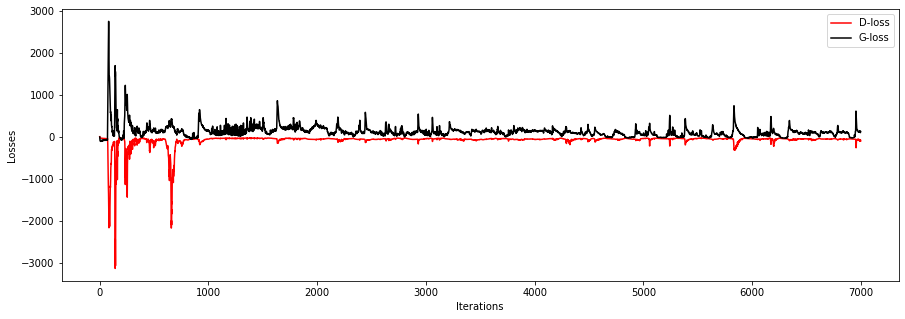

Iteration 7000, d_loss=-94.32, g_loss=129.21


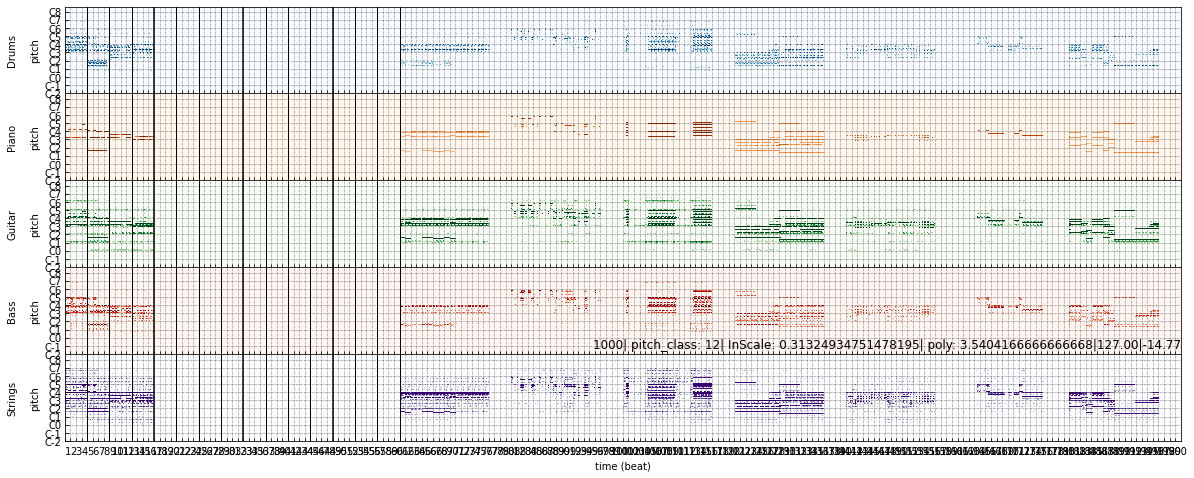

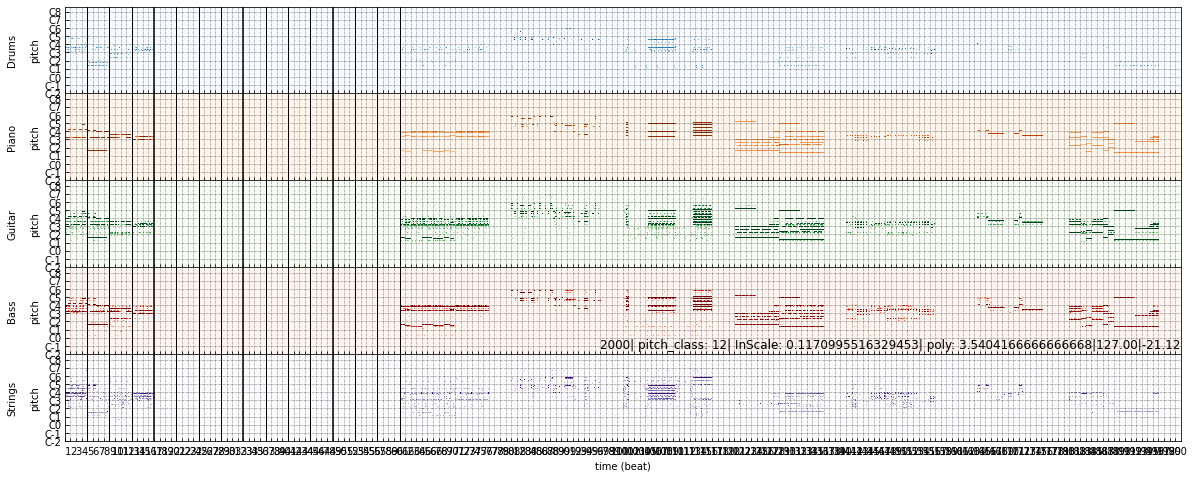

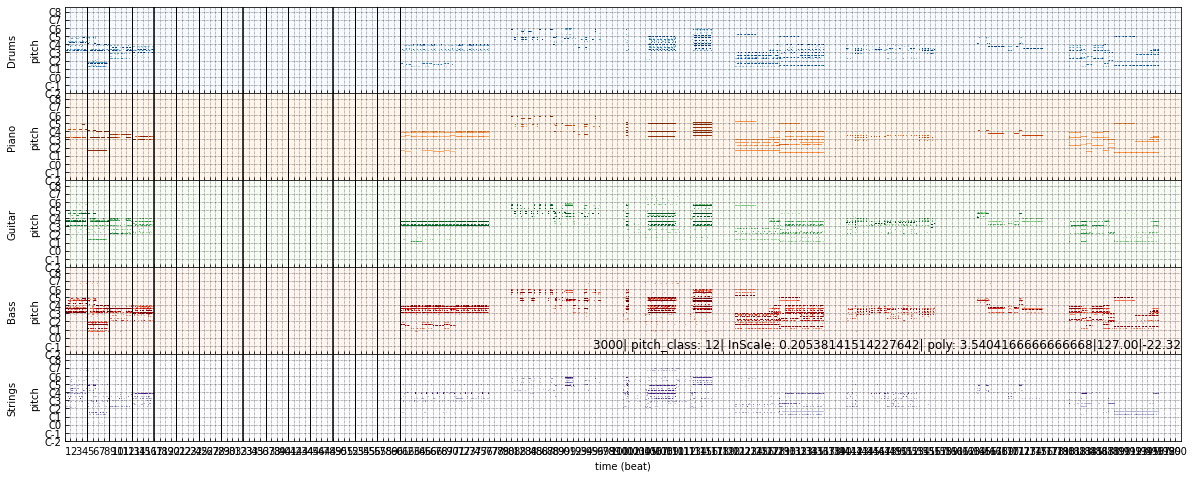

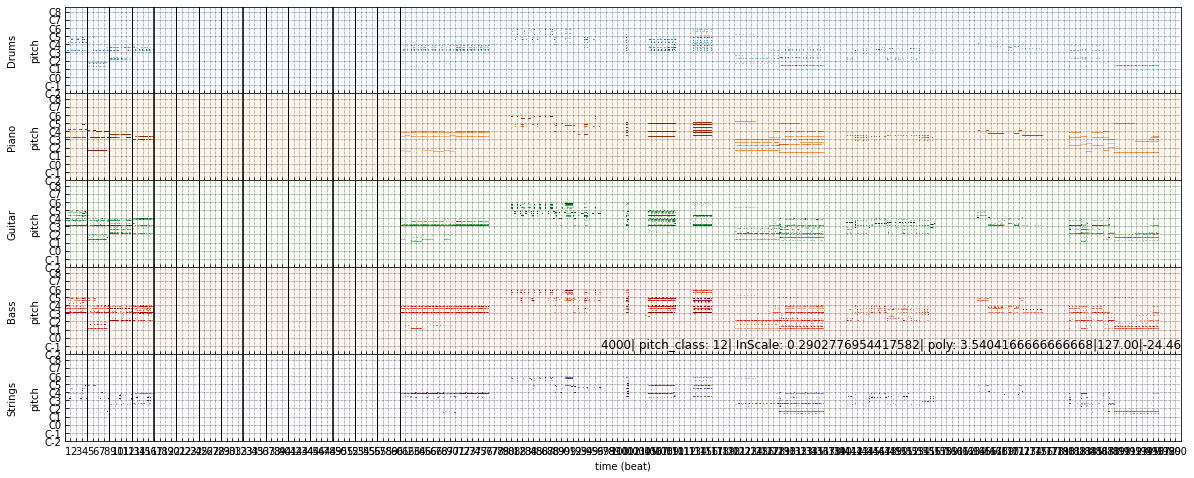

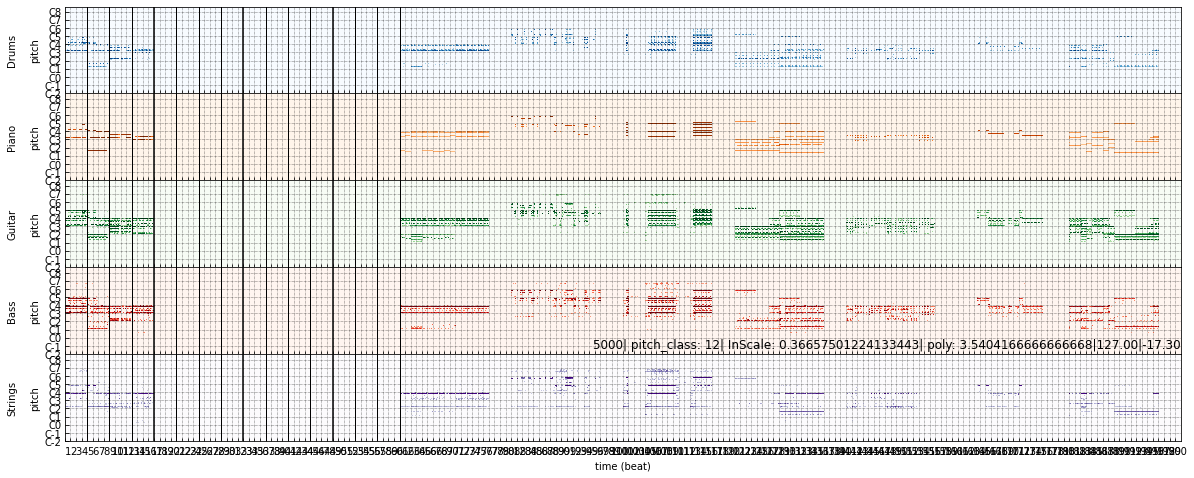

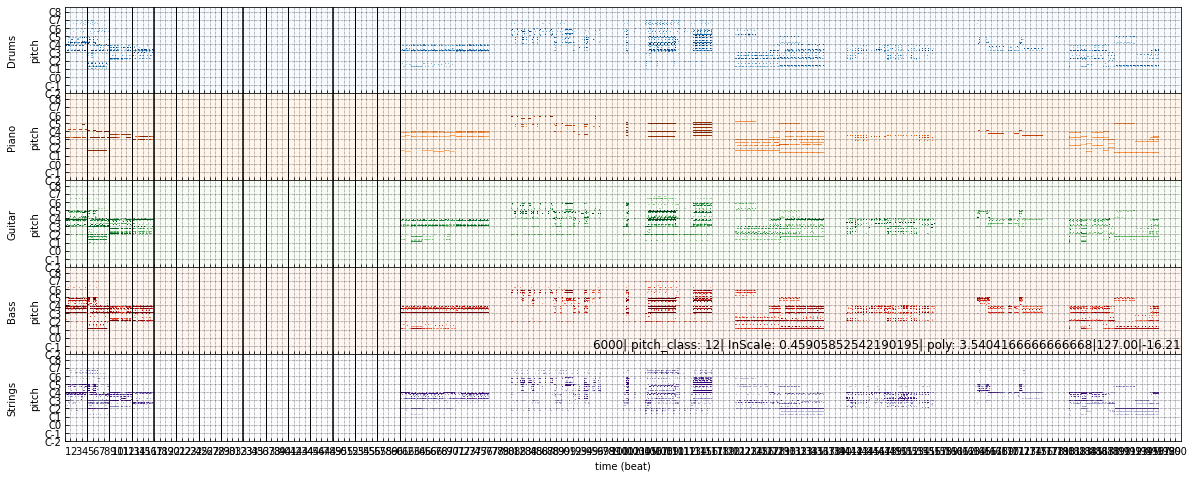

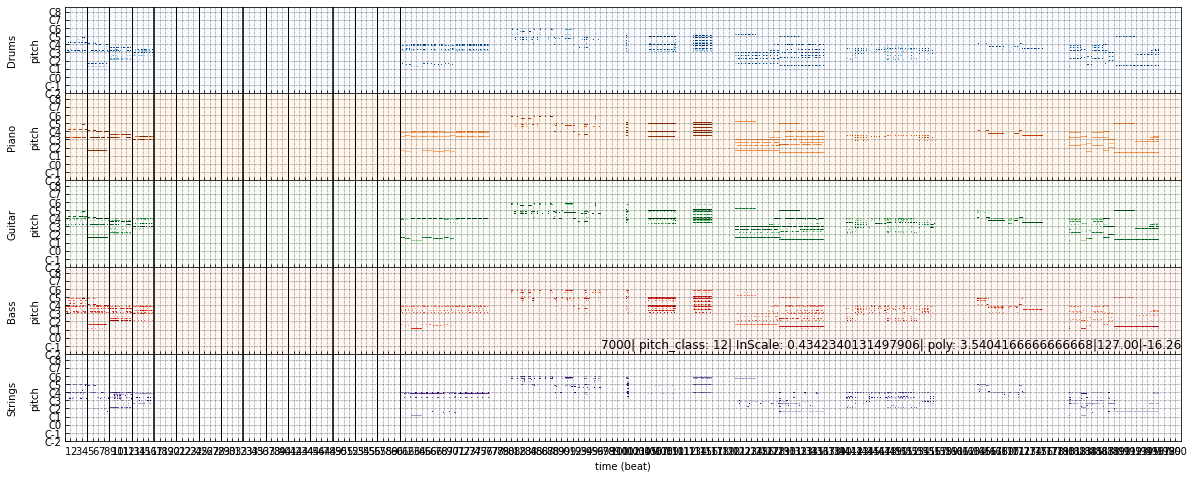

In [32]:
c_losses = []
g_losses = []

with strategy.scope():
    
    data = strategy.experimental_distribute_dataset(dataset)
    it = iter(data)
    init_lr = 1e-3
    lr_schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(init_lr, decay_steps=1000)
    # Setup Adam optimizers for both G and D
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_fn, beta_1=0.5, beta_2=0.9)
    critic_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_fn, beta_1=0.5, beta_2=0.9)    
    
    # We define our checkpoint directory and where to save trained checkpoints
    ckpt = tf.train.Checkpoint(generator=generator,
                            generator_optimizer=generator_optimizer,
                            critic=discriminator,
                            critic_optimizer=critic_optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, CHECK_DIR, max_to_keep=5)
    # print(type(it))
    for iteration in range(1, epoch+1):

        for _ in range(n_dis_updates_per_gen_update):
            c_loss = _critic_train_step(next(it), condition_track_idx=1)

        
        g_loss = _generator_train_step(next(it), condition_track_idx=1)

        c_losses.append(c_loss)
        g_losses.append(g_loss)
        
        display.clear_output(wait=True)
        fig = plt.figure(figsize=(15, 5))
        line1, = plt.plot(range(iteration), c_losses, 'r')
        line2, = plt.plot(range(iteration), g_losses, 'k')
        plt.xlabel('Iterations')
        plt.ylabel('Losses')
        plt.legend((line1, line2), ('D-loss', 'G-loss'))
        display.display(fig)
        plt.close(fig)
        
        print('Iteration {}, d_loss={:.2f}, g_loss={:.2f}'.format(iteration, c_loss, g_loss))
        
        if (iteration) % 1000 == 0 :
            
            fake_sample_x = generator((sample_c, sample_z), training=False)

            ckpt_manager.save(checkpoint_number=(iteration))
            
            fake_sample_x = fake_sample_x.numpy()
            
            # print(fake_sample_x.shape) # (10, 4, 48, 84, 5)
            save_pianoroll(fake_sample_x, programs, is_drums, tempo_array, beat_resolution, lowest_pitch, step=iteration)
            np.save(f"{os.path.join(RUN_FOLDER, 'sample_data')}/sample_{iteration}_fake_sample_x.npy", fake_sample_x)

In [33]:
ckpt = tf.train.Checkpoint(generator=generator)
ckpt_manager = tf.train.CheckpointManager(ckpt, CHECK_DIR, max_to_keep=5)

In [34]:
ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
print('Latest checkpoint {} restored.'.format(ckpt_manager.latest_checkpoint))

Latest checkpoint run/compose/77_lpd_5/weights/ckpt-7000 restored.


In [35]:
def generate_pianoroll(generator, conditioned_track, noise_vector=None):
    if noise_vector == None:
        noise_vector = tf.random.truncated_normal((1, latent_dim))
    return generator((conditioned_track, noise_vector), training=False)

In [36]:
def get_conditioned_track(midi=None, phrase_length=192, beat_resolution=12):
    
    if not isinstance(midi, str):
        # ----------- Generation from preprocessed dataset ------------------
        sample_x = midi
        sample_c = np.expand_dims(sample_x[..., 0], -1)
    else:
        # --------------- Generation from midi file -------------------------
        midi_file = midi

        parsed = pypianoroll.read(midi_file)
        parsed.set_resolution(beat_resolution)

        sample_c = parsed.tracks[0].pianoroll.astype(np.float32)
        
        # Remove initial steps that have no note-on events
        first_non_zero = np.nonzero(sample_c.sum(axis=1))[0][0]
        
        # Use the first 'phrase_length' steps as the primer
        sample_c = sample_c[first_non_zero: first_non_zero + phrase_length]

        # Binarize data (ignore velocity value)
        sample_c[sample_c > 0] = 1
        sample_c[sample_c <= 0] = -1

        sample_c = np.expand_dims(np.expand_dims(sample_c, 0), -1)  # 1, 32, 128, 1
        sample_c = sample_c[:, :, lowest_pitch:lowest_pitch+n_pitches, :]
        sample_c = sample_c.reshape(-1, 4, 48, 84, 1)
    sample_c = tf.convert_to_tensor(sample_c, dtype=tf.float32)
    return sample_c

In [37]:
user_input_files = os.listdir('./user_input_data')

In [38]:
user_input_files

['shark.mid', '보고싶다.mid', 'CauseILoveU.mid', '먼지가되어.mid', '옹달샘.mid']

In [39]:
USER_INPUT_PATH = f'./user_input_data/{user_input_files[0]}'
print(USER_INPUT_PATH)
conditioned_track = get_conditioned_track(midi=USER_INPUT_PATH)
generated_pianoroll = generate_pianoroll(generator, conditioned_track)

./user_input_data/shark.mid


In [40]:
pianoroll = generated_pianoroll.numpy()

# pianoroll = np.round( 0.5 * (pianoroll + 1.0 ))
reshaped = pianoroll.reshape(
    -1, pianoroll.shape[1] * pianoroll.shape[2], pianoroll.shape[3],
    pianoroll.shape[4])

# Pad to the correct pitch range and add silence between phrases
to_pad_pitch_high = 128 - lowest_pitch - pianoroll.shape[3]
padded = np.pad(reshaped, ((0, 0), (0, pianoroll.shape[2]),
                (lowest_pitch, to_pad_pitch_high), (0, 0)), 'constant')

# Reshape the batched pianoroll array to a single pianoroll array
pianoroll_ = padded.reshape(-1, padded.shape[2], padded.shape[3])

In [41]:
answer = pianoroll_.transpose(2, 0, 1)

In [42]:
answer.shape

(5, 240, 128)

In [43]:
answer.max(), answer.min()

(23.98946, -16.259136)

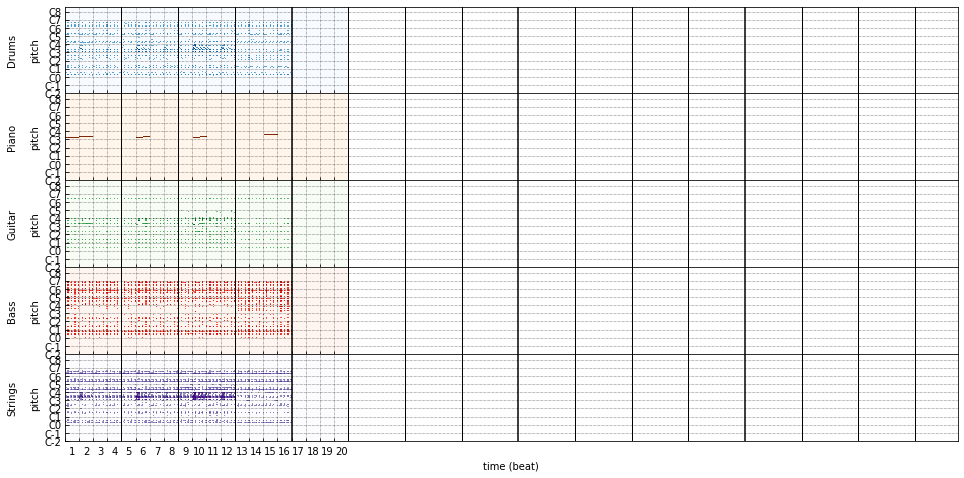

In [44]:
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    temp_arr = answer[idx]
    # print(temp_arr.max())
    temp_arr = temp_arr / temp_arr.max()
    temp_arr[temp_arr < 0.5] = 0.0
    temp_arr = temp_arr * 127.0
    temp_arr = temp_arr[ :, lowest_pitch:lowest_pitch + n_pitches]
    temp_arr = np.pad(temp_arr, ( (0,0), (lowest_pitch, 128 - lowest_pitch - n_pitches)  ))

    #print(f"In Scale Rate: {pypianoroll.metrics.in_scale_rate(temp_arr, root=3, mode='major')}")
    tracks.append(
        StandardTrack(
            name=track_name,
            program=program,
            is_drum=is_drum,
            pianoroll=temp_arr,
        )
    )
m = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
#m_data = muspy.from_pypianoroll(m)

axs = m.plot()
for ax in axs:
    for x in range(
        measure_resolution,
        4 * measure_resolution * n_measures,
        measure_resolution
    ):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.gcf().set_size_inches((16, 8))
plt.show()

In [45]:
import time
m.write(f'{RUN_FOLDER}/viz/{USER_INPUT_PATH.split("/")[-1].split(".")[0]}_{time.strftime(("%Y_%m_%d-%H_%M_%S"))}_output.mid')

In [46]:
import gc
gc.collect()

5548349

In [47]:
# from IPython.display import Video
# import moviepy.editor as mpy

# def make_training_video(folder_dir):
#     files = sorted([os.path.join(folder_dir, f) for f in os.listdir(folder_dir) if f.endswith('.png')])
#     frames = [mpy.ImageClip(f).set_duration(1) for f in files]  
#     clip = mpy.concatenate_videoclips(frames, method="compose")
#     clip.write_videofile("movie.mp4",fps=15) 
#     return Video("movie.mp4")

In [48]:
temp_data = np.random.normal(size=(10, 4, 48, 84, 5))

print(temp_data.transpose(0, 1, 2, 3, 4).shape)
print(np.concatenate(temp_data, axis=0).shape)

(10, 4, 48, 84, 5)
(40, 48, 84, 5)
